In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor-classification-mri:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F672377%2F1183165%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240518%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240518T140139Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D618069f1b66c27ab367e69e2fc34cf313f71e702f1d81813bba53a651ddf4925d1ea0259fbd3df3e69c0f7a0b240835611d9bad368fb195c9580bfa3dc8b34d235fa4f5de26852a05948070359ee16cbf02b871af27562162d0e9706fe11f57f41ed4912ebc719d556759b9663b9fdf279f7110db9eeb1830154b2f100578511fe3a81e7dac9b71095d6d1711bc836e19a795dbd8a09ce37aa2fe3591b4c8302dbe3649a6fa50741f53aa6bc99cfd80b8c46f4739572a4688330fba3f815fff15e479153415ce0c60b70432e6c1a356f58221a785abfadc1b881a6498a6521dec61e1e32881caaa591fb1ed988bfb1d44dd8684f28c3a15f207df5ec63a7a7ff'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 91002358 bytes downloaded
Downloaded and uncompressed: brain-tumor-classification-mri
Data source import complete.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, concatenate, Input, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
import cv2
from sklearn.utils import shuffle

In [ ]:
train_dir = '/kaggle/input/brain-tumor-classification-mri/Training'
test_dir = '/kaggle/input/brain-tumor-classification-mri/Testing'

In [ ]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
X_train = []
Y_train = []
image_size = 128
num_classes = 4
for label in labels:
    train_path = os.path.join(train_dir, label)
    for j in os.listdir(train_path):
        img = cv2.imread(os.path.join(train_path, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        mask = np.zeros((image_size, image_size, num_classes))
        mask[:, :, labels.index(label)] = 1
        Y_train.append(mask)

for label in labels:
    test_path = os.path.join(test_dir, label)
    for j in os.listdir(test_path):
        img = cv2.imread(os.path.join(test_path, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        mask = np.zeros((image_size, image_size, num_classes))
        mask[:, :, labels.index(label)] = 1
        Y_train.append(mask)

# we will put both training and tesing data as train data and will split it after
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_train = X_train/255.0

In [ ]:
print(X_train.shape)
print(Y_train.shape)

(3264, 128, 128, 3)
(3264, 128, 128, 4)


In [ ]:
print(f"{X_train.shape}\n{np.min(X_train)}\n{np.max(X_train)}\n{Y_train.shape}")

(3264, 128, 128, 3)
0.0
1.0
(3264, 128, 128, 4)


Text(0.5, 1.0, 'glioma_tumor')

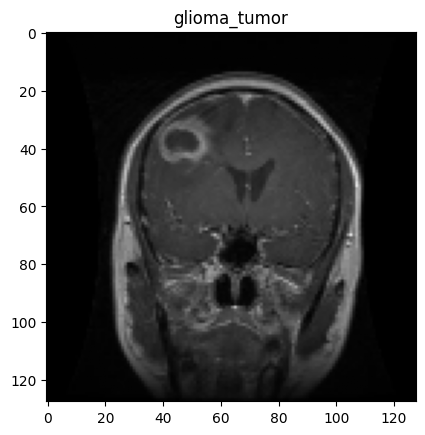

In [ ]:
plt.imshow(X_train[1])
plt.title(labels[np.argmax(Y_train[1])])

In [ ]:
X_train.shape + Y_train.shape

(3264, 128, 128, 3, 3264, 128, 128, 4)

In [ ]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=101)

In [ ]:
X_train.shape + Y_train.shape

(3264, 128, 128, 3, 3264, 128, 128, 4)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=101)

In [ ]:
X_train.shape + X_test.shape + Y_train.shape + Y_test.shape

(2937, 128, 128, 3, 327, 128, 128, 3, 2937, 128, 128, 4, 327, 128, 128, 4)

In [ ]:
def double_conv(x, num_filters):
    x = Conv2D(num_filters, 3, activation='relu', padding='same')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same')(x)
    return x;

def down_sampling(x, num_filters):
    x = double_conv(x, num_filters)
    p = MaxPooling2D(2)(x)
    p = Dropout(0.3)(p)
    return x, p

def up_sampling(x, conv_feature, num_filters):
    x = Conv2DTranspose(num_filters, 3, 2, padding='same')(x)
    x = concatenate([x, conv_feature])
    x = Dropout(0.3)(x)
    x = double_conv(x, num_filters)
    return x

In [ ]:
def unet_model(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    # Encoder / Down Sampling
    c1, p1 = down_sampling(inputs, 64)
    c2, p2 = down_sampling(p1, 128)
    c3, p3 = down_sampling(p2, 256)
    c4, p4 = down_sampling(p3, 512)
    # Bottle Neck
    b1 = double_conv(p4, 1024)
    # Decoder / Up Sampling
    c5 = up_sampling(b1, c4, 512)
    c6 = up_sampling(c5, c3, 256)
    c7 = up_sampling(c6, c2, 128)
    c8 = up_sampling(c7, c1, 64)

    outputs = Conv2D(4, 1, activation='softmax', padding='same')(c8)

    model = Model(inputs, outputs, name='U-Net')

    return model

In [ ]:
model = unet_model()
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

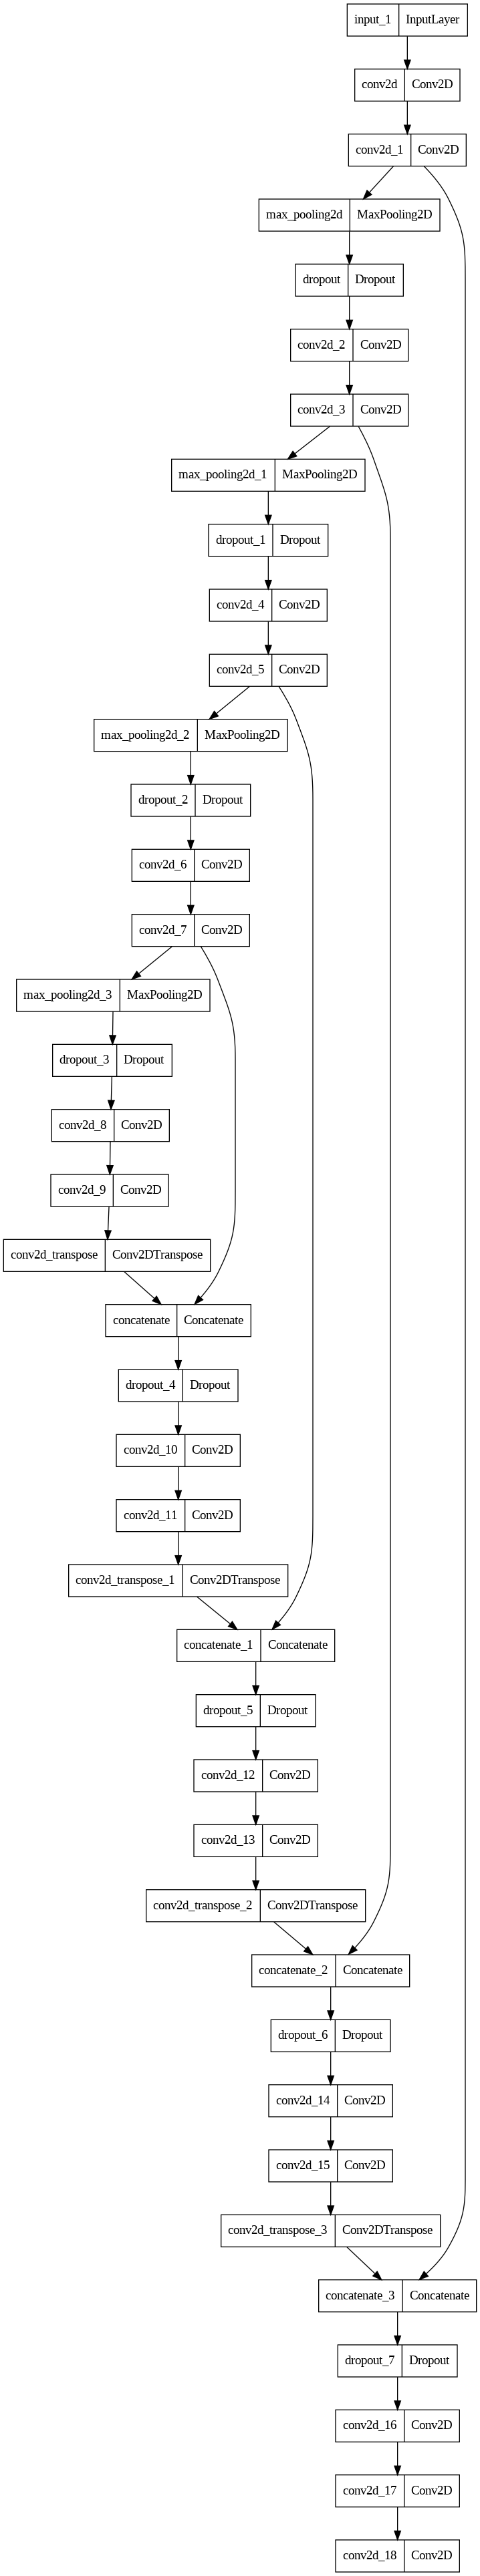

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file="/kaggle/working/model.png", show_layer_names=True)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, epochs=10, validation_split=0.15)

Epoch 1/10
52/78 [===================>..........] - ETA: 22:54 - loss: 1.3565 - accuracy: 0.3149

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


In [ ]:
import tensorflow_addons as tfa

def calculate_dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(Y_test)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Predict on the validation set
y_val_pred = model.predict(X_test)

# Calculate Dice Coefficient
dice_scores = []
for i in range(len(y_val_pred)):
    dice_scores.append(calculate_dice_coefficient(Y_val[i], y_val_pred[i]))

average_dice_score = np.mean(dice_scores)
print(f"Average Dice Coefficient: {average_dice_score}")


In [ ]:
def plot_sample(X, y_true, y_pred, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(X[index])
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.imshow(np.argmax(Y_test[index], axis=-1))
    plt.title('True Mask')
    plt.subplot(1, 3, 3)
    plt.imshow(np.argmax(y_pred[index], axis=-1))
    plt.title('Predicted Mask')
    plt.show()

# Plot sample predictions
plot_sample(X_test, Y_test, y_val_pred, index=0)


In [ ]:
'''
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('unet_brain_tumor.h5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[checkpoint])
'''